In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib

from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
cmap = 'plasma'

In [2]:
def radial_background_mass_preserving(I_obs, Q_obs, Q_eval, mu_, eps=1e-12, use_log_metric=False):
    """
    Mass-preserving Nadaraya–Watson smoother with a single column-normalized kernel.

    Shapes:
      M = len(Q_obs), L = len(Q_eval)
      K, W: (M, L)
      I_radial_eval: (L,)
      I_radial_obs : (M,)
    """
    I_obs  = np.asarray(I_obs, dtype=float).ravel()
    Q_obs  = np.asarray(Q_obs, dtype=float).ravel()
    Q_eval = np.asarray(Q_eval, dtype=float).ravel()
    M, L = Q_obs.size, Q_eval.size
    assert I_obs.size == M, "I_obs and Q_obs must have same length"

    if use_log_metric:
        # helpful if features vary rapidly at small Q
        qo = np.log(Q_obs)
        qe = np.log(Q_eval)
    else:
        qo = Q_obs
        qe = Q_eval

    # --- One kernel, one normalization (columns sum to 1) ---
    # K[m, ℓ] = exp(- (Q_obs[m] - Q_eval[ℓ])^2 / (2 mu_^2))
    K = np.exp(-((qo[:, None] - qe[None, :])**2) / (2.0 * mu_**2))     # (M, L)
    colsum = K.sum(axis=0, keepdims=True)                               # (1, L)
    colsum = np.maximum(colsum, eps)
    W = K / colsum                                                       # (M, L), columns sum to 1

    # obs -> eval
    I_radial_eval = W.T @ I_obs                                          # (L,)

    # eval -> obs (mass-preserving back-projection)
    w_eff = W @ np.ones(L)                                               # (M,)
    w_eff = np.maximum(w_eff, eps)
    I_radial_obs = (W @ I_radial_eval) / w_eff                           # (M,)

    return I_radial_eval, I_radial_obs, W

In [3]:
## Identification of principal axis 
def f_pl_obs(qx_obs, qy_obs, I_obs):
    qxqx = np.sum(I_obs * qx_obs * qx_obs)
    qxqy = np.sum(I_obs * qx_obs * qy_obs)
    qyqy = np.sum(I_obs * qy_obs * qy_obs)
    R = [[qxqx, qxqy], [qxqy, qyqy]]
    eigenvalues, eigenvectors = np.linalg.eig(R)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    pl_eigen = np.arctan2(principal_axis[1], principal_axis[0])
    return pl_eigen

def f_C(theta, n, theta_0=0, bg=True, use_prime=False):
    """
    Construct a symmetric cosine basis matrix evaluated at given angles.

    Parameters:
    - theta: array-like, angles where basis is evaluated (in radians)
    - n: number of non-constant cosine modes (n > 0)
    - theta_0: alignment angle for symmetry shift
    - bg: if True, include constant (isotropic) term in first column

    Returns:
    - C: (len(theta), n+1) array if bg=True, else (len(theta), n) array
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    n_list = 2 * (np.arange(n) + 1)  # modes: 2, 4, ..., 2n
    
    # Generate candidate p values: 1, 2, 3, 4, ..., and filter
    if use_prime:
        from sympy import isprime
        p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
        # Take the first `n` values
        p_list = p_list[:n]
        # Now generate n_list = 2 * p
        n_list = 2 * np.array(p_list)

    C_cos = np.cos(np.outer(theta_shift, n_list))  # shape (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))  # constant term
        C = np.concatenate([C_0, C_cos], axis=1)  # (M, n+1)
    else:
        C = C_cos  # (M, n)

    return C

def f_CS(theta, n, theta_0=0, bg=True, use_prime=False):
    """
    Construct a real-valued Fourier basis with symmetric cosine and sine terms.

    Parameters:
    - theta: array-like, input angles in radians
    - n: number of cosine/sine harmonics (positive integers)
    - theta_0: alignment angle (shifts all basis functions)
    - bg: if True, include constant term as first column

    Returns:
    - C: (len(theta), 2n+1) if bg=True, else (len(theta), 2n)
         Columns ordered as [1, cos(2θ), ..., cos(2nθ), sin(2θ), ..., sin(2nθ)]
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    n_list = 2 * (np.arange(n) + 1)  # modes: 2, 4, ..., 2n
    
    # Generate candidate p values: 1, 2, 3, 4, ..., and filter
    if use_prime:
        from sympy import isprime
        p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
        # Take the first `n` values
        p_list = p_list[:n]
        # Now generate n_list = 2 * p
        n_list = 2 * np.array(p_list)

    C_cos = np.cos(np.outer(theta_shift, n_list))  # (M, n)
    C_sin = np.sin(np.outer(theta_shift, n_list))  # (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))
        C = np.concatenate([C_0, C_cos, C_sin], axis=1)  # (M, 2n+1)
    else:
        C = np.concatenate([C_cos, C_sin], axis=1)       # (M, 2n)

    return C

def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))

def bayesian_inference_ratio(I_obs, delta_I_obs, Q_obs, theta_obs, delta_Q, Q_eval, C_basis, mu_, lambda_,
                              mode="forward", log_transform=False, sine_basis=False, q_low=0.03, scale_low=0):
    """
    Perform Bayesian inference on the modulation I(Q, theta) / I_radial(Q).

    Parameters:
    - log_transform: if True, calculate the radial average on log I
    - sine_basis: if True, include sine basis functions
    - q_low: anisotropic coefficient vanishing at low q

    Returns:
    - A_MAP: MAP estimate of the harmonic coefficients (L x N)
    - I_radial_eval: estimated radial profile I_radial(Q_eval)
    """
    L = len(Q_eval)
    M = len(Q_obs)
    N = C_basis.shape[1]

    print(f"L (Q_eval): {L}, M (obs): {M}, N (basis): {N}")
    
    if log_transform:
        x_c = np.mean(I_obs)
        y_c = np.log(x_c)

        f_I = lambda I: f_loglin(I, x_c)
        f_inv_I = lambda fI: f_loglin_inv(fI, y_c)

        # --- Radial background estimation in transformed space ---
        fI_obs = f_I(I_obs)
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        fI_radial_eval = W_Qeval_from_Qobs.T @ fI_obs  # shape (L,)
        I_radial_eval = f_inv_I(fI_radial_eval)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        fI_radial_obs = W_Qobs_from_Qeval @ fI_radial_eval  # shape (M,)
        I_radial_obs = f_inv_I(fI_radial_obs)
    else:
        # # --- Radial background estimation ---
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        # W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        # I_radial_eval = W_Qeval_from_Qobs.T @ I_obs  # shape (L,)

        # # --- Project radial profile back to observations ---
        # K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        # W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        # I_radial_obs = W_Qobs_from_Qeval @ I_radial_eval  # shape (M,)
        
        I_radial_eval, I_radial_obs, W = radial_background_mass_preserving(
            I_obs=I_obs, Q_obs=Q_obs, Q_eval=Q_eval, mu_=mu_
        )
        
        # I_radial_eval, I_radial_obs = radial_background_regularized(
        #     I_obs=I_obs,
        #     Q_obs=Q_obs,
        #     Q_eval=Q_eval,
        #     mu_=mu_,
        #     lambda_=lambda_,           # choose/tune this
        #     delta_I_obs=None           # or provide per-point uncertainties
        # )
    

    # --- Normalize observations ---
    I_mod = I_obs / I_radial_obs
    delta_I_mod = delta_I_obs / I_radial_obs

    # --- Construct design matrix (M x LN) ---
    G = (K_Qobs_to_Qeval[:, :, None] * C_basis[:, None, :]).reshape(M, L * N)

    # --- Prior covariance ---
    Q_diff_sq = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    K_spatial = np.exp(-Q_diff_sq / (2 * lambda_ ** 2))
    K_spatial_full = np.kron(np.eye(N), K_spatial)

    from sympy import isprime
    p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
    # Take the first `n` values
    p_list = p_list[:N-1]
    if sine_basis:
        p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
        p_list = p_list[:(N-1)//2]
        p_list = [val for p in p_list for val in (p, p)]
    # Now generate n_list = 2 * p
    angular_penalty = np.array([0] + [(2*n) for n in p_list])
    
    # angular_penalty = np.array([0] + [(2*n) for n in range(1, N)])
    K_angular = np.kron(np.diag(angular_penalty), np.eye(L))
    
    # --- Q-dependent penalty (decaying as Q^{-2}) for harmonics n >= 1 ---
    Q_penalty = np.zeros((L, N))
    Q_weight = q_low**2 / np.maximum(Q_eval**2, 1e-6)  # avoid div-by-zero at Q = 0
    # Q_weight = np.exp(-Q_eval**2/2/q_low**2)  # exponential decay for low Q

    for j in range(1, N):
        Q_penalty[:, j] = Q_weight

    # Flatten to a diagonal penalty matrix
    K_lowQ = np.diag(Q_penalty.flatten())

    K_prior = K_spatial_full + K_angular + K_lowQ*scale_low

    # --- Prior mean ---
    A_prior_mean = np.zeros((L, N))
    A_prior_mean[:, 0] = 1.0 
    A_prior_flat = A_prior_mean.flatten()

    # --- Observation noise covariance ---
    Sigma = np.diag(delta_I_mod**2)

    # --- MAP Inference ---
    if mode == "forward":
        Sigma_inv = np.diag(1.0 / delta_I_mod**2)
        GT_Sinv = G.T @ Sigma_inv
        K_tilde_inv = GT_Sinv @ G + np.linalg.inv(K_prior) 
        K_tilde_inv = K_tilde_inv + 1e-6 * np.eye(K_tilde_inv.shape[0])
        rhs = GT_Sinv @ (I_mod - G @ A_prior_flat)
        # A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        try:
            A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        except np.linalg.LinAlgError:
            print("Cholesky failed, falling back to np.linalg.solve")
            A_post_flat = A_prior_flat + np.linalg.solve(K_tilde_inv, rhs)
        
    elif mode == "dual":
        residual = I_mod - G @ A_prior_flat
        G_K = G @ K_prior
        K_tilde = G_K @ G.T + Sigma
        A_post_flat = A_prior_flat + K_prior @ G.T @ cho_solve(cho_factor(K_tilde), residual)
    else:
        raise ValueError("mode must be 'forward' or 'dual'")

    A_MAP = A_post_flat.reshape(L, N)
    return A_MAP, I_radial_eval

def reconstruct_I_q(Q_eval, theta_eval, A_MAP, f_basis, mu_, theta_0=0.0,
                    direct=False, bg=True, I_radial_eval=None, log_transform=False, sine_basis = False):
    """
    Reconstruct the intensity modulation I(Q, theta)/I_radial(Q) or log-form.

    Parameters:
    - log_transform: If True, A_MAP represents log(I / I_radial)

    Returns:
    - I_modulated: shape (K, L), modulation (I / I_radial) or exp(log modulation)
    """
    L, N = A_MAP.shape
    K = len(theta_eval)

    # Angular basis matrix (K, N)
    C_arr = f_basis(theta_eval, N - 1 if bg else N, theta_0=theta_0, bg=bg)
    if sine_basis:
        C_arr = f_CS(theta_eval, (N - 1)//2 if bg else N//2, theta_0=theta_0, bg=bg)

    if direct:
        I_modulated = C_arr @ A_MAP.T  # (K, L)
    else:
        spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))  # (L, L)
        I_modulated = (spatial_kernel_eval @ A_MAP) @ C_arr.T  # (L, K)
        I_modulated = I_modulated.T  # shape (K, L)

    # Restore full I(Q, theta) if bg was removed
    if not bg:
        if I_radial_eval is None:
            raise ValueError("Must provide I_radial_eval if bg=False")
        I_modulated *= I_radial_eval[None, :]  # elementwise multiply

    return I_modulated

def reconstruct_I_q_ratio(Q_eval, theta_eval, A_MAP, f_basis, mu_, I_radial_eval,
                          theta_0=0.0, direct=False, log_transform=False, sine_basis = False):
    """
    Reconstruct full I(Q, theta) from inferred modulation coefficients and radial profile.

    Parameters:
    - log_transform: If True, treat A_MAP as log(I/I_radial)

    Returns:
    - I_full: (K, L) reconstructed intensity I(Q, theta)
    - I_mod:  (K, L) modulation (I/I_radial) or exp(log modulation)
    """
    I_mod = reconstruct_I_q(
        Q_eval, theta_eval, A_MAP, f_basis, mu_,
        theta_0=theta_0, direct=direct, bg=True,
        I_radial_eval=None, log_transform=log_transform, sine_basis = sine_basis
    )

    I_full = I_mod * I_radial_eval[None, :]  # restore I(Q, theta)
    return I_full, I_mod


In [4]:
import os

filepath = 'data/ILL_0805/CTABSDBS/'
filenames = os.listdir(filepath)
print(filenames)

data_list = []
for filename in filenames:
    if filename.endswith('.dat'):
        data = np.loadtxt(filepath + filename, skiprows=0)
        data_list.append(data)

['CTABSDBS_t3_17_1mLmin.dat', 'CTABSDBS_t3_07_0p2mLmin.dat', 'CTABSDBS_t3_04_0p036mLmin.dat', 'CTABSDBS_t3_02_0mLmin50bar.dat', 'CTABSDBS_t3_09_0p632mLmin.dat', 'CTABSDBS_t3_16_7mLmin.dat', 'CTABSDBS_t3_11_2mLmin.dat', 'CTABSDBS_t3_15_5mLmin.dat', 'CTABSDBS_t3_05_0p063mLmin.dat', 'CTABSDBS_t3_06_0p112mLmin.dat', 'CTABSDBS_t3_13_2p5mLmin.dat', 'CTABSDBS_t3_08_0p356mLmin.dat', 'CTABSDBS_t3_01_0mLmin.dat', 'CTABSDBS_t3_03_0p02mLmin.dat', 'CTABSDBS_t3_12_0p02mLmin.dat', 'CTABSDBS_t3_14_3mLmin.dat', 'CTABSDBS_t3_18_0mLmin.dat', 'CTABSDBS_t3_10_1p12mLmin.dat']


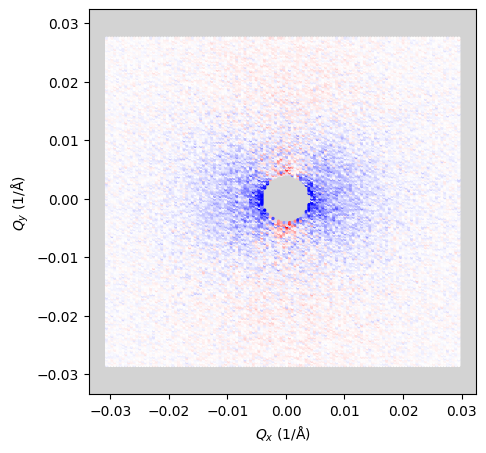

In [5]:
data_0 = data_list[0]
Qx_obs = data_0[:, 0]
Qy_obs = data_0[:, 1]
I_obs_0 = data_0[:, 2]
delta_I_obs_0 = data_0[:, 3]
Q_obs = np.sqrt(Qx_obs**2 + Qy_obs**2)
theta_obs = np.arctan2(Qy_obs, Qx_obs)

valid_mask_detector = (Qx_obs < 0.0364)
Qx_obs = Qx_obs[valid_mask_detector]
Qy_obs = Qy_obs[valid_mask_detector]
I_obs_0 = I_obs_0[valid_mask_detector]
delta_I_obs_0 = delta_I_obs_0[valid_mask_detector]
Q_obs = Q_obs[valid_mask_detector]
theta_obs = theta_obs[valid_mask_detector]

data = data_list[17]
I_obs = data[:, 2]
delta_I_obs = data[:, 3]
I_obs = I_obs[valid_mask_detector]
delta_I_obs = delta_I_obs[valid_mask_detector]

index_horizontal = np.where((np.abs(theta_obs) < 0.1) | (np.abs(theta_obs - np.pi) < 0.1))[0]
Qx_obs_horizontal = Qx_obs[index_horizontal]
min_r_horizontal = np.max([np.min(Qx_obs_horizontal[Qx_obs_horizontal > 0]), np.min(-Qx_obs_horizontal[Qx_obs_horizontal < 0])])
index_vertical = np.where((np.abs(theta_obs - np.pi/2) < 0.1) | (np.abs(theta_obs + np.pi/2) < 0.1))[0]
Qy_obs_vertical = Qy_obs[index_vertical]
min_r_vertical = np.max([np.min(Qy_obs_vertical[Qy_obs_vertical > 0]), np.min(-Qy_obs_vertical[Qy_obs_vertical < 0])])
min_r_stop = np.sqrt(min_r_horizontal**2 + min_r_vertical**2)

valid_mask_stop = (Q_obs > min_r_stop)
# valid_mask_stop only covers the indices where valid_mask_detector is True,
# so we need to expand it to match the original array shape.
# Create a mask that is False everywhere except where valid_mask_detector is True,
# and set those entries to valid_mask_stop.
valid_mask = np.zeros_like(valid_mask_detector, dtype=bool)
valid_mask[valid_mask_detector] = valid_mask_stop

Qx_obs = Qx_obs[valid_mask_stop]
Qy_obs = Qy_obs[valid_mask_stop]
Q_obs = Q_obs[valid_mask_stop]
theta_obs = theta_obs[valid_mask_stop]

I_obs_0 = I_obs_0[valid_mask_stop]
delta_I_obs_0 = delta_I_obs_0[valid_mask_stop]

I_obs = I_obs[valid_mask_stop]
delta_I_obs = delta_I_obs[valid_mask_stop]


# visualize loaded data
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111) 

ax.scatter(Qx_obs, Qy_obs, c=I_obs-I_obs_0, s=2, cmap='bwr', vmin=-100, vmax=100)

# disc = Circle((0, 0), min_r_stop, edgecolor='k', facecolor='k', linewidth=0)
# ax.add_patch(disc)

ax.set_xlabel(r'$Q_x$ (1/Å)')
ax.set_ylabel(r'$Q_y$ (1/Å)')

# plt.colorbar(ax.collections[0], ax=ax, label=r'$I(Q_x, Q_y)$')
ax.set_facecolor('lightgray')

ax.set_xlim([-0.0037, 0.0037])
ax.set_ylim([-0.0037, 0.0037])
plt.axis('equal')
plt.show()

In [10]:
data_list_used = data_list[-1:]
for i_data, data in enumerate(data_list_used):
    Qx_obs = data[:, 0]
    Qy_obs = data[:, 1]
    I_obs = data[:, 2]
    delta_I_obs = data[:, 3]
    Q_obs = np.sqrt(Qx_obs**2 + Qy_obs**2)
    theta_obs = np.arctan2(Qy_obs, Qx_obs)
    
    # apply valid_mask
    Qx_obs = Qx_obs[valid_mask]
    Qy_obs = Qy_obs[valid_mask]
    I_obs = I_obs[valid_mask]
    delta_I_obs = delta_I_obs[valid_mask]
    Q_obs = Q_obs[valid_mask]
    theta_obs = theta_obs[valid_mask]
    
    # GPR
    # Q for evaluation
    Q_eval = np.linspace(min_r_stop, 0.03, 101)  # Define Q_eval range
    theta_eval = np.linspace(-np.pi, np.pi, 360, endpoint=False)
    pl_eigen = np.pi/2  # radians

    # --- Step 3: Angular basis setup (include constant term for I/I_radial) ---
    n = 6
    bg = True  # Must include constant term
    C_arr = f_C(theta_obs, n, theta_0=pl_eigen, bg=bg)

    # --- Step 4: Inference parameters ---
    lambda_ = 0.004
    mu_ = lambda_
    delta_Q = Q_eval[1] - Q_eval[0]
    log_transform = False  # <--- Enable log-transformed inference
    eps = 1e-8  # small positive number to prevent log(0) 
    
    sine_basis = False  # <--- Use cosine basis only
    
    # --- Step 5: Perform Bayesian inference ---
    A_MAP, I_radial_eval = bayesian_inference_ratio(
        I_obs, delta_I_obs, Q_obs, theta_obs, delta_Q, Q_eval,
        C_arr, mu_, lambda_, mode="dual", log_transform=log_transform,
        sine_basis=sine_basis, q_low=0.03, scale_low=0
    )

    # --- Step 6: Reconstruct full I(Q, theta) ---
    I_eval, I_mod = reconstruct_I_q_ratio(
        Q_eval, theta_eval, A_MAP, f_C, mu_, I_radial_eval,
        theta_0=pl_eigen, direct=False, log_transform=log_transform,
        sine_basis=sine_basis
    )
    
    # Inferred results ---------------------------------------------------------------
    # Total number of pixels (needed for normalization)
    # Evaluate grids and flat
    Q_eval_grid, theta_eval_grid = np.meshgrid(Q_eval, theta_eval)
    Qx_eval = Q_eval_grid * np.cos(theta_eval_grid)
    Qy_eval = Q_eval_grid * np.sin(theta_eval_grid)

    # flat
    I_eval_flat = I_eval.flatten()

    # Compute radial backgrounds
    I_eval_radial = np.mean(I_eval, axis=0)[None, :]
    I_eval_radial_flat = np.tile(I_eval_radial, (len(theta_eval), 1)).flatten()

    # Shuffle indices
    index_shuffle = np.arange(I_eval_flat.size)
    np.random.shuffle(index_shuffle)

    # Apply shuffle to everything
    theta_eval_flat = theta_eval_grid.flatten()[index_shuffle]
    Q_eval_flat = Q_eval_grid.flatten()[index_shuffle]
    Qx_eval_flat = Qx_eval.flatten()[index_shuffle]
    Qy_eval_flat = Qy_eval.flatten()[index_shuffle]
    I_eval_flat = I_eval_flat[index_shuffle]
    I_eval_radial_flat = I_eval_radial_flat[index_shuffle]
    


L (Q_eval): 101, M (obs): 29880, N (basis): 7


(-0.03365925, 0.03254425, -0.0312981, 0.0302161)

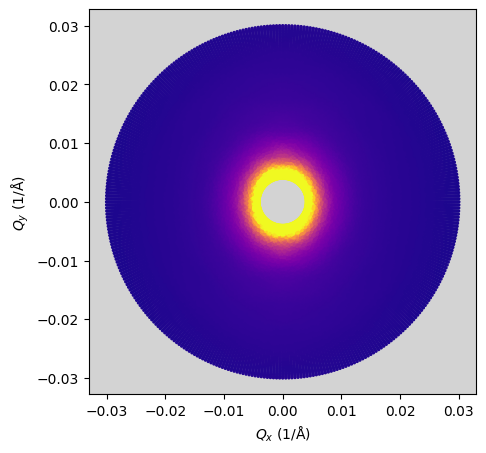

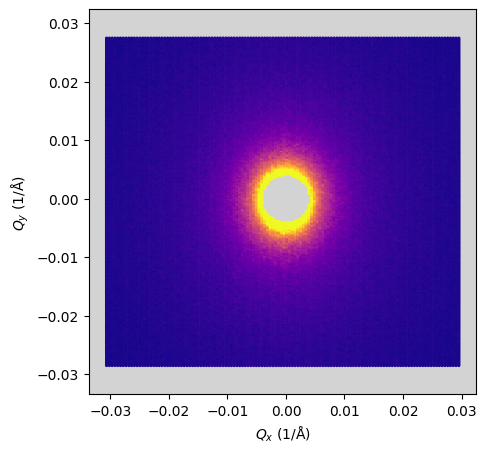

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Plot the inferred intensity
sc = ax.scatter(Qx_eval_flat, Qy_eval_flat, c=I_eval_flat, s=2, cmap=cmap, vmin=0, vmax=300)
ax.set_xlim([-0.0037, 0.0037])
ax.set_ylim([-0.0037, 0.0037])
ax.set_xlabel(r'$Q_x$ (1/Å)')
ax.set_ylabel(r'$Q_y$ (1/Å)')
ax.set_facecolor('lightgray')
plt.axis('equal')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111) 

# Plot the raw data intensity
ax.scatter(Qx_obs, Qy_obs, c=I_obs, s=2, cmap=cmap, vmin=0, vmax=300)
ax.set_xlim([-0.0037, 0.0037])
ax.set_ylim([-0.0037, 0.0037])
ax.set_xlabel(r'$Q_x$ (1/Å)')
ax.set_ylabel(r'$Q_y$ (1/Å)')
ax.set_facecolor('lightgray')
plt.axis('equal')